# NLP Disaster Tweets Kaggle Mini-Project


## Brief description of the problem and data 

In this mini-project, we shall build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We shall have access to a dataset of 10,000 tweets that were hand-classified apriori, hence contain groud-truth labels. We shall use a **binary text classification model** which will be trained on these tweets and then later will be used to predict the class labels for an unseen test data.

Given a train and a test csv file, where each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

We shall predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster. That's where the classifier will be useful.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

First we need to import all `python` packages / functions (need to install with `pip` if some of them are not already installed) that are required to the clean the texts (from the tweets), for building the RNN models and for visualization. We shall use `tensorflow / keras` to to train the deep learning models. 

In [ ]:
import numpy as np 
import pandas as pd 
import os, math

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#for text cleaning
import string, re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#for data analysis and modeling
import tensorflow as tf
import tensorflow_hub as hub
# !pip install tensorflow_text
import tensorflow_text 
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Dropout
from tensorflow.keras.layers import TextVectorization
tf.__version__
# 2.12.0

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

Read the train and test dataframe, the only columns that we shall use are *text* (to extract input features) and *target* (output to predict).

In [3]:
df_train = pd.read_csv('nlp-getting-started/train.csv', index_col='id')
df_test = pd.read_csv('nlp-getting-started/test.csv', index_col='id')
df_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


There around 7.6k tweets in the training and 3.2k tweets in the test dataset, respectively.

In [4]:
df_train.shape, df_test.shape

((7613, 4), (3263, 3))

Maximum number of words present in a tweet is 31, for both training and test dataset

In [5]:
max_len_train = max(df_train['text'].apply(lambda x: len(x.split())).values)
max_len_test = max(df_train['text'].apply(lambda x: len(x.split())).values)
max_len_train, max_len_test

(31, 31)

The following plot shows histogram of class labels, the number of positive (disaster) and negative (no distaster) classes in the training dataset. As can be seen, the dataset is slightly imbalanced.

0    4342
1    3271
Name: target, dtype: int64

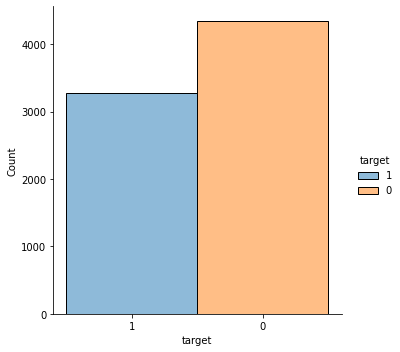

In [48]:
#train_df['target'] = train_df['target'].astype(str)
sns.displot(data=train_df, x='target', hue='target')
train_df['target'].value_counts()

Now, let's use the wordcloud library to find the most frequent words in disaster tweets and normal tweets. As we can see, 

* the top 10 most frequent words in disaster tweets (with class label 1) are: 'fire', 'New', 'via', 'disaster', 'California', 'suicide', 'U', 'police', 'amp', 'people'
* the top 10 most frequent words in the normal tweets (with class label 0) are: 'new', 'amp', 'u', 'one', 'body', 'time', 'video', 'via', 'day', 'love'

top 10 words: ['fire', 'New', 'via', 'disaster', 'California', 'suicide', 'U', 'police', 'amp', 'people']


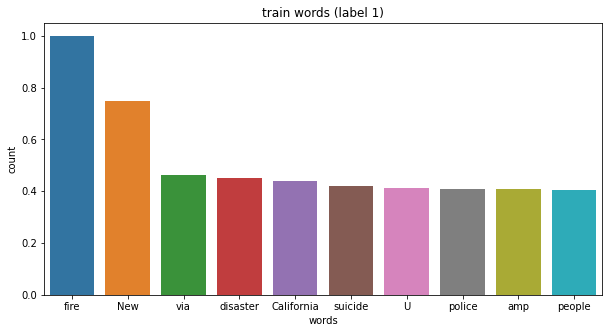

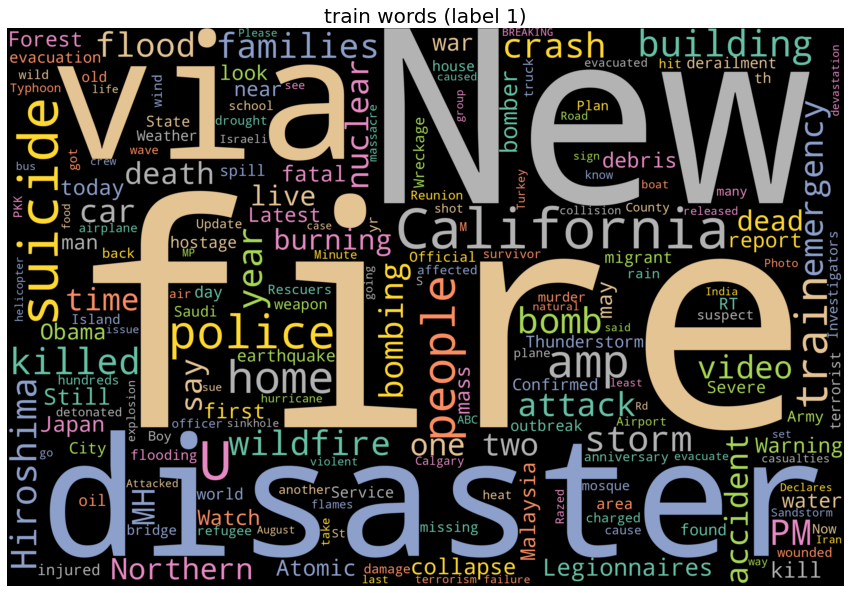

top 10 words: ['new', 'amp', 'u', 'one', 'body', 'time', 'video', 'via', 'day', 'love']


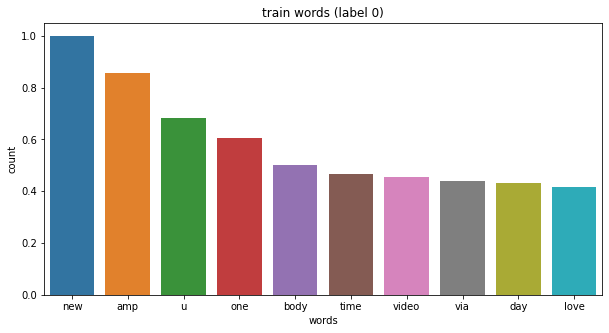

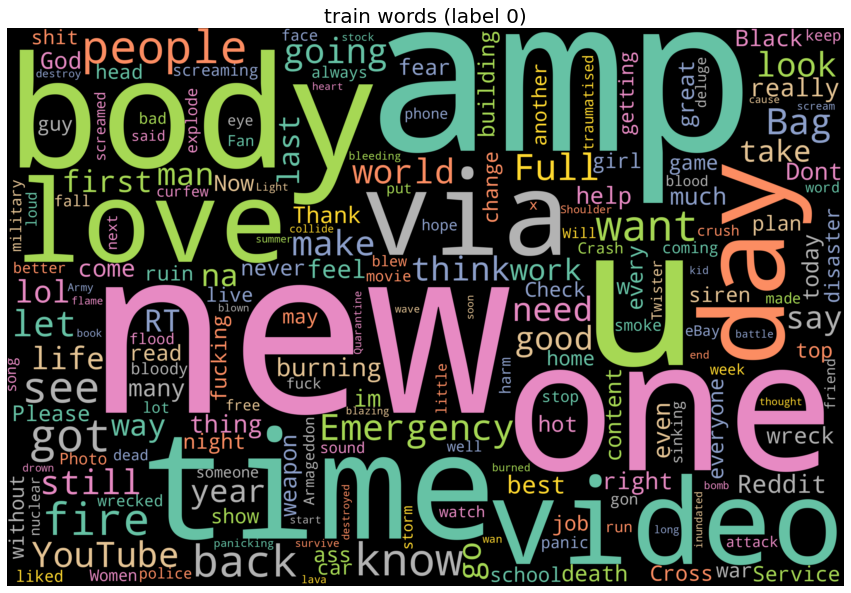

In [86]:
def plot_wordcloud(text, title, k=10):
  # Create and Generate a Word Cloud Image
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  # top k words
  plt.figure(figsize=(10,5))
  print(f'top {k} words: {list(wordcloud.words_.keys())[:k]}')
  ax = sns.barplot(x=0, y=1, data=pd.DataFrame(wordcloud.words_.items()).head(k))
  ax.set(xlabel = 'words', ylabel='count', title=title)
  plt.show()
  #Display the generated image
  plt.figure(figsize=(15,15))
  plt.imshow(wordcloud, interpolation="bilinear"), plt.title(title, size=20), plt.axis("off")
  plt.show()

plot_wordcloud(' '.join(df_train[df_train['target']==1]['text'].values), 'train words (label 1)')
plot_wordcloud(' '.join(df_train[df_train['target']==0]['text'].values), 'train words (label 0)')

## Preprocessing / Cleaning

Since the tweet texts are likely to contain many junk characters, very common non-informative words (*stopwords*, e.g., 'the'), it is a good idea to clean the text (with the function `clean_text()` as shown below) and remove unnecessary stuffs before building the models, otherwise they can affect the performance. It's important that we apply the same preprocessing on both the training and test tweets.

In [17]:
def clean_text(txt):
    """""
    cleans the input text by following the steps:
    * replace contractions
    * remove punctuation
    * split into words
    * remove stopwords
    * remove leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    #remove numbers
    txt = re.sub('[0-9]+', '', txt)
    #txt = txt.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ", regex = True )
    txt = txt.str.lower() # lowercase
    txt = txt.str.replace(r"\#","", regex = True ) # replaces hashtags
    txt = txt.str.replace(r"http\S+","URL", regex = True )  # remove URL addresses
    txt = txt.str.replace(r"@","", regex = True )
    text = text.str.replace("\s{2,}", " ", regex = True ) # remove multiple contiguous spaces
    return text
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text

# clean train and test tweets
df_train['text'] = df_train['text'].apply(lambda txt: clean_text(txt))
df_test['text'] = df_test['text'].apply(lambda txt: clean_text(txt))

df_train.head()

CPU times: user 2.05 s, sys: 101 ms, total: 2.15 s
Wall time: 2.16 s


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
5,NaN,NaN,All residents asked shelter place notified off...,1
6,NaN,NaN,people receive wildfires evacuation orders Cal...,1
7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1


## Model Architecture 

We shall use multiple models, starting from LSTM/GRU/BiLSTM to BERT and USE. 

## LSTM / GRU

Let's start with vanilla LSTM / GRU model. We need to start by tokenizing the texts followed adding appropriate pads to the token sequence (to have the seuqence length fixed, e.g. equal to `max_len`)

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(df_train['text'].values, df_train['target'].values, shuffle=True, test_size=0.2)

max_len = max(df_train['text'].apply(lambda x: len(x.split())).values)
max_words = 20000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

print('text example:', xtrain[0])
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

text example: Witness video shows car explode behind burning buildings nd St afternoon Manchester httptcocgmJlSEYLo via MikeCroninWMUR
sequence of indices(before padding): [17, 29, 37, 9]
sequence of indices(after padding): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 17 29 37  9]


We shall first use a pretrained (semantic) embedding from *Global Vectors for Word Representation* (**GloVe**) model (dowload the pretrained weights) and create a word-level embedding matrix as shown below. Later we shall use `LSTM` to train the embedding on our own.

In [1]:
#https://nlp.stanford.edu/projects/glove/
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip g*zip

In [33]:
%%time
embedding_vectors = {}
with open('glove.6B.300d.txt','r',encoding='utf-8') as file: #glove.42B.300d.txt
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")  

Size of vocabulary in GloVe: 400000
CPU times: user 33.1 s, sys: 1.55 s, total: 34.7 s
Wall time: 33.4 s


In [34]:
#initialize the embedding_matrix with zeros
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: []
0 out of 50 words were OOV.


Let's create the model with and `Embedding` layer followed by the `LSTM` layer and add a bunch of `Dense` layers on top. We shall first use pretrained GloVe embeddings and then later build another model to train the embeddings from the data provided.

In [27]:
lstm_model = Sequential(name='model_lstm')
lstm_model.add(Embedding(vocab_len, emb_dim), trainable = False, weights=[embedding_matrix])
#lstm_model.add(Embedding(vocab_len, emb_dim), trainable = True)
lstm_model.add(LSTM(64, activation='tanh', return_sequences=False))
lstm_model.add(Dense(128, activation='relu'))
#lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(Dropout(0.2)) # Adding Dropout layer with rate of 0.2
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
lstm_model.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                93440     
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8

Now, let's create the model using `GRU` layer instead of LSTM, as shown in the following code snippet.

In [28]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential(name='model_gru')
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

Model: "model_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         6000000   
                                                                 
 gru_1 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,165,249
Trainable params: 165,249
Non-trainable params: 6,000,000
_________________________________________________________________
None


## BiLSTM

Now, let's create a Bidirection LSTM model instead, this time using `TextVectorization`: a preprocessing layer which maps text features to integer sequences. Let's create training and validation datasets for model evaluation, by applying the vectorizer on the text tweets.

In [43]:
# Define Embedding layer as pre-processing layer for tokenization
max_features = 20000 #  20000 most frequent words in the input text data.

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=200, output_mode='int') 
vectorizer.adapt(np.hstack((X_train, X_test))) 
vectorizerd_text = vectorizer(X_train)

dataset = tf.data.Dataset.from_tensor_slices((vectorizerd_text, y_train))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32) 
dataset = dataset.prefetch(8)
batch_X, batch_y = dataset.as_numpy_iterator().next()

train = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

model_bilstm = Sequential(name='model_bilstm')
model_bilstm.add(Embedding(max_features + 1, 64))
model_bilstm.add(Bidirectional(LSTM(64, activation='tanh')))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dropout(0.2)) # Adding Dropout layer with dropout rate of 0.2
model_bilstm.add(Dense(256, activation='relu'))
model_bilstm.add(Dense(128, activation='relu'))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=[Recall()])
model_bilstm.summary()

Model: "model_bilstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280064   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                      

## BERT

Next, let's use the *Bidirectional Encoder Representations from Transformers* (BERT) model for the text classification. The function `get_BERT_model()` uses the BERT model as backbone, extracts the *pooled_output* layer and adds a couple of `Dense` layers (with `Dropout` regularizer) on top of it, as shown in thee next code snippet.

In [3]:
def get_BERT_model():
    # Preprocessing
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    # Bert encoder
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweets')
    x = bert_preprocess_model(input_layer)
    x = bert_model(x)['pooled_output']
    x = tf.keras.layers.Dropout(0.5)(x) #Optional, to eliminate overfitting
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    classification_out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
    bert_preprocess_model._name = "preprocess"
    bert_model._name = "bert_encoder"
    model_bert = tf.keras.Model(input_layer, classification_out)
    model_bert._name = "model_bert"
    return model_bert

model_bert = get_BERT_model()
model_bert.summary()

Model: "model_bert"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tweets (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['tweets[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                             

## Universal Sequence Encoder Model (USE)

Finally, we shall use the *Universal Sentence Encoder* to obtain sentence level embedding, along with our regular `Dense` layers to create a binary text classification model.

In [ ]:
transfer_model_url = 'https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1'
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],  # shape of inputs coming to our model
                                        dtype=tf.string,  # data type of inputs coming to the USE layer
                                        trainable=False,
                                        # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

model_use = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
], name = 'transfer_mode')
model_use.summary()

Model: "transfer_mode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 16)                8208      
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 256,806,321
Trainable params: 8,497
Non-trainable params: 256,797,824
_________________________________________________________________


## Results and Analysis

Let's now fit the models on the training dataset and compare the performance of the model (in terms of accuracy, recall and ROC AUC) on the held-out validation daatset. The metric *Recall* is more important than *precision* / *accuracy* here becuase we shall like our model to capture as many of the true disaster tweets as possibile.

## LSTM / GRU

The LSTM model was trained for 50 epochs (10 epochs are shown below) and the accuracy did not seem to improve over time (obtained ~66% accuracy on validation).

### Hyperparameter Tuning

* Number of LSTM units and batch size were varied to see the impact on performance, but the model did almost the same.

* First the model was trained with pe-trained **GloVe** `Embedding` layers and then later the `Embedding` layer was trained from the data, but the accuracies did not improve much.

In [36]:
# model_lstm.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
# with pretrained GloVe weights
%%time
batch_size = 32
epochs  = 50
history = model_lstm.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
24/24 [==============================] - 9s 31ms/step - loss: 0.6367 - accuracy: 0.6448 - val_loss: 0.6179 - val_accuracy: 0.6586
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.6084 - accuracy: 0.6727 - val_loss: 0.6110 - val_accuracy: 0.6579
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5995 - accuracy: 0.6757 - val_loss: 0.6132 - val_accuracy: 0.6586
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5980 - accuracy: 0.6749 - val_loss: 0.6093 - val_accuracy: 0.6573
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 0.5944 - accuracy: 0.6780 - val_loss: 0.6093 - val_accuracy: 0.6573
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 0.5907 - accuracy: 0.6777 - val_loss: 0.6089 - val_accuracy: 0.6586
Epoch 7/10
24/24 [==============================] - 0s 12ms/step - loss: 0.5899 - accuracy: 0.6793 - val_loss: 0.6106 - val_accuracy: 0.6559
Epoch 8/10
24/24

In [69]:
# model_lstm.add(Embedding(vocab_len, emb_dim)) #, trainable = True, weights=[embedding_matrix]))
# learning the embedding layer weights
%%time
batch_size = 32
epochs  = 50
history = model_lstm.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/50
191/191 [==============================] - 8s 22ms/step - loss: 0.6320 - recall: 0.2882 - auc_11: 0.6650 - val_loss: 0.6123 - val_recall: 0.3474 - val_auc_11: 0.6984
Epoch 2/50
191/191 [==============================] - 2s 9ms/step - loss: 0.6052 - recall: 0.3603 - auc_11: 0.7016 - val_loss: 0.6170 - val_recall: 0.3444 - val_auc_11: 0.6962
Epoch 3/50
191/191 [==============================] - 2s 8ms/step - loss: 0.6030 - recall: 0.3665 - auc_11: 0.7073 - val_loss: 0.6135 - val_recall: 0.3068 - val_auc_11: 0.6978
Epoch 4/50
191/191 [==============================] - 2s 9ms/step - loss: 0.6002 - recall: 0.3496 - auc_11: 0.7048 - val_loss: 0.6307 - val_recall: 0.3053 - val_auc_11: 0.6973
Epoch 5/50
191/191 [==============================] - 2s 12ms/step - loss: 0.6022 - recall: 0.3546 - auc_11: 0.7090 - val_loss: 0.6123 - val_recall: 0.3323 - val_auc_11: 0.6946
Epoch 6/50
191/191 [==============================] - 2s 9ms/step - loss: 0.5945 - recall: 0.3538 - auc_11: 0.7112 - v

The GRU model was trained for 50 epochs (12 epochs are shown below) and the accuracy did not seem to improve over time (obtained ~67% accuracy on validation).

In [57]:
batch_size = 32
epochs  = 50
history = model_gru.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)

Epoch 1/10
24/24 [==============================] - 4s 27ms/step - loss: 0.6316 - accuracy: 0.6466 - val_loss: 0.6128 - val_accuracy: 0.6586
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6050 - accuracy: 0.6708 - val_loss: 0.6150 - val_accuracy: 0.6592
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.5999 - accuracy: 0.6744 - val_loss: 0.6110 - val_accuracy: 0.6586
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5977 - accuracy: 0.6750 - val_loss: 0.6109 - val_accuracy: 0.6559
Epoch 5/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5968 - accuracy: 0.6745 - val_loss: 0.6103 - val_accuracy: 0.6691
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 0.5925 - accuracy: 0.6785 - val_loss: 0.6086 - val_accuracy: 0.6592
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 0.5918 - accuracy: 0.6826 - val_loss: 0.6125 - val_accuracy: 0.6592
Epoch 8/10
24/24 

## BiLSTM

This model was trained with `TextVectorization` as preprocessing layer. This time recall was used as evaluation metric. This model performed quite well an achived over 98% validation recall, as shown in the next figure too. This model is the second best performing model (in terms of bulic score) on the unseen test dataset.

In [44]:
hist= model_bilstm.fit(train, epochs=30, batch_size=32, validation_data=val)

Epoch 1/30
166/166 [==============================] - 29s 101ms/step - loss: 0.5638 - recall_1: 0.4101 - val_loss: 0.3570 - val_recall_1: 0.7625
Epoch 2/30
166/166 [==============================] - 6s 34ms/step - loss: 0.3524 - recall_1: 0.7582 - val_loss: 0.2676 - val_recall_1: 0.8138
Epoch 3/30
166/166 [==============================] - 5s 30ms/step - loss: 0.2598 - recall_1: 0.8562 - val_loss: 0.1658 - val_recall_1: 0.9122
Epoch 4/30
166/166 [==============================] - 4s 26ms/step - loss: 0.1861 - recall_1: 0.9017 - val_loss: 0.1183 - val_recall_1: 0.9609
Epoch 5/30
166/166 [==============================] - 4s 23ms/step - loss: 0.1278 - recall_1: 0.9400 - val_loss: 0.0879 - val_recall_1: 0.9745
Epoch 6/30
166/166 [==============================] - 3s 19ms/step - loss: 0.0929 - recall_1: 0.9624 - val_loss: 0.0485 - val_recall_1: 0.9685
Epoch 7/30
166/166 [==============================] - 4s 27ms/step - loss: 0.0659 - recall_1: 0.9642 - val_loss: 0.0504 - val_recall_1: 0.97

<Figure size 576x360 with 0 Axes>

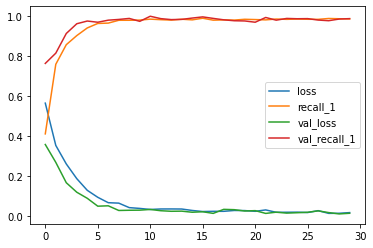

In [47]:
plt.figure(figsize=(8, 5))
pd.DataFrame(hist.history).plot()
plt.show()

### Predictions

Before computing the prediction, we need to preprocess the test tweets by applying `TextVectorization`.

In [ ]:
vectorizerd_test_text = vectorizer(X_test)
preds = []
for input_text in vectorizerd_test_text:    
    pred = model.predict(np.expand_dims(input_text, 0))    
    preds.append(pred)

preds = np.round(np.array(preds))
sub_sample = pd.read_csv('sample_submission.csv')
sub_sample['target'] = preds.flatten()
sub_sample['target'] = sub_sample['target'].astype('int')
sub_sample.to_csv('submission.csv', index=False)

## BERT

Since the training data is a little imbalanced, we shall compute the class weights and use them in the loss function to compensate the imbalance.

In [3]:
class_weights = compute_class_weight(class_weight = "balanced", 
                                     classes = np.unique(df_train["target"]),
                                     y= df_train["target"])
class_weights = {k:class_weights[k] for k in np.unique(df_train["target"])}
class_weights

{0: 0.8766697374481806, 1: 1.1637114032405993}

The model was trained for 20 epochs with `Adam` optimizer and weighted `BCE` loss function. We can change the optimizer and use `AdamW` or `SGD` instead and observe the result on hyperparameter tuning. This model happened to be a competitor of the BiLSTM model above, in terms of performance score obtained on the unseen test data.

In [ ]:
epochs = 20
batch_size = 32 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) #logits = data come forom direct output without sigmoid.
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]

model_bert.get_layer('bert_encoder').trainable = True # need to train

model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)

train_data = df_train.sample(frac=0.8,random_state=200)
valid_data = df_train.drop(train_data.index)

In [19]:
history = model_bert.fit(x=df_train.text.values, 
                                          y=df_train.target.values,
                                          class_weight=class_weights,
                                          epochs=epochs,
                                          batch_size = batch_size,
                                          validation_data=(valid_data.text.values, valid_data.target.values))

Epoch 1/20
238/238 [==============================] - 58s 206ms/step - loss: 0.5457 - binary_accuracy: 0.7416 - auc_1: 0.7982 - val_loss: 0.3832 - val_binary_accuracy: 0.8549 - val_auc_1: 0.9162
Epoch 2/20
238/238 [==============================] - 31s 130ms/step - loss: 0.4084 - binary_accuracy: 0.8330 - auc_1: 0.8898 - val_loss: 0.2670 - val_binary_accuracy: 0.9009 - val_auc_1: 0.9514
Epoch 3/20
238/238 [==============================] - 28s 120ms/step - loss: 0.3271 - binary_accuracy: 0.8795 - auc_1: 0.9269 - val_loss: 0.2485 - val_binary_accuracy: 0.9284 - val_auc_1: 0.9711
Epoch 4/20
238/238 [==============================] - 27s 113ms/step - loss: 0.2649 - binary_accuracy: 0.9087 - auc_1: 0.9500 - val_loss: 0.1660 - val_binary_accuracy: 0.9462 - val_auc_1: 0.9828
Epoch 5/20
238/238 [==============================] - 27s 114ms/step - loss: 0.2208 - binary_accuracy: 0.9237 - auc_1: 0.9656 - val_loss: 0.1767 - val_binary_accuracy: 0.9409 - val_auc_1: 0.9879
Epoch 6/20
238/238 [=====

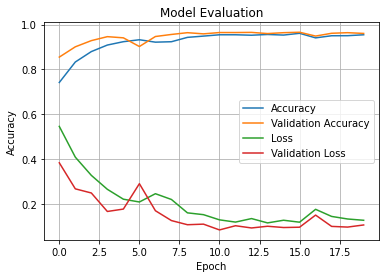

In [20]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history['val_binary_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()

plot_hist(history)

### Prediction on the test dataset

In [21]:
X_test = df_test["text"].values
predictions_prob = model_bert.predict(X_test)
predictions = tf.round(predictions_prob)
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission2.csv', index=False)
submission.head()

102/102 [==============================] - 7s 60ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


## Model USE

Finally, the *Universal Sentence Embedding* model was trained, it outperformed all the models and obtained more than 80% public score on *Kaggle* on the test dataset.

In [ ]:
X, y = df_train['text'].values, df_train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X.shape, y.shape

((7613,), (7613,))

In [ ]:
model_use.compile(loss = tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy',tf.keras.metrics.AUC()])

In [ ]:
%%time
history = model_use.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 8s 30ms/step - loss: 0.5605 - accuracy: 0.7578 - auc_10: 0.8121 - val_loss: 0.4440 - val_accuracy: 0.8078 - val_auc_10: 0.8804
Epoch 2/10
179/179 [==============================] - 3s 15ms/step - loss: 0.4336 - accuracy: 0.8073 - auc_10: 0.8754 - val_loss: 0.4184 - val_accuracy: 0.8157 - val_auc_10: 0.8838
Epoch 3/10
179/179 [==============================] - 3s 15ms/step - loss: 0.4150 - accuracy: 0.8164 - auc_10: 0.8840 - val_loss: 0.4131 - val_accuracy: 0.8214 - val_auc_10: 0.8848
Epoch 4/10
179/179 [==============================] - 3s 15ms/step - loss: 0.4053 - accuracy: 0.8199 - auc_10: 0.8889 - val_loss: 0.4117 - val_accuracy: 0.8193 - val_auc_10: 0.8852
Epoch 5/10
179/179 [==============================] - 4s 22ms/step - loss: 0.3997 - accuracy: 0.8247 - auc_10: 0.8912 - val_loss: 0.4109 - val_accuracy: 0.8193 - val_auc_10: 0.8856
Epoch 6/10
179/179 [==============================] - 4s 24ms/step - loss: 0.3900 - accuracy: 0

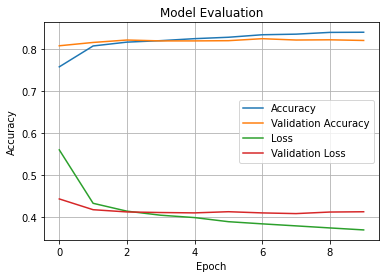

In [ ]:
def plot_hist(hist):
    '''
    Plots the training / validation loss and accuracy given the training history
    '''
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model Evaluation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.grid()
    plt.show()
    
plot_hist(history)

### Prediction and Submission to Kaggle

In [ ]:
X_test = df_test['text'].values
predictions_prob = model_use.predict(X_test)
predictions = tf.round(predictions_prob)

102/102 [==============================] - 1s 10ms/step


In [ ]:
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = predictions
submission['target'] =submission['target'].astype(int)
submission['id'] = df_test.index
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Conclusion 

The Sentence-level Embedding (USE) model performed the best on the test data (*Kaggle* public score ~81.1%), whereas *BiLSTM* and *BERT* models did decent jobs. Surprisingly, the USE model performed pretty well without any preprocessing. Training *BERT* for longer time may improve the accuracy of the transfomer on the test dataset. The next screenshots show the *Kaggle* public scores obtained for different submissions and the **leaderboard** position for the best sumission is **265**, as of now.

![](submission_.png)

![](leaderboard.png)